### Customized Dialog-MNIST DataLoader
- Generates random digits at random positions on a 128x128 canvas.
- Digits have attributes like color, background color, and style. 
- Creates overlapping digits
- Returns: Images, Labels, Bounding Boxes, Colors, 

In [4]:
import numpy as np
# from mnist_util import read
#from num2words import num2words
import operator as op
import json
import scipy.misc
import os
import struct
import random

from PIL import Image
from scipy.ndimage.morphology import grey_dilation
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
# from data.dialog_mnist_utils import *

np.random.seed(123)

# possible properties/ attributes
colors = ['blue', 'red', 'green', 'violet', 'brown']
bgcolors = ['white', 'cyan', 'salmon', 'yellow', 'silver']
styles = ['flat', 'stroke']
properties = ['number', 'color', 'bgcolor', 'style']

In [2]:
# Build the attributes 
def generateGridImg(size=3):
    img = []
    for i in range(size):
        img.append([])
        for j in range(size):
            cell = {}
            cell['number'] = np.random.randint(10)
            cell['color'] = colors[np.random.randint(len(colors))]
            cell['bgcolor'] = bgcolors[np.random.randint(len(bgcolors))]
            cell['style'] = styles[np.random.randint(len(styles))]
            img[i].append(cell)
    return img

def printGridImg(img):
    for i in range(len(img)):
        for k in img[0][0]:
            for j in range(len(img[i])):
                grid_dict['number'] = img[i]
                # grid_dict['color'] = img[i][j]
                print( k, img[i][j][k], '\t'),
            print
        print
        
def initTargetMap(size=3):
    targetMap = []
    for i in range(size):
        targetMap.append([])
        for j in range(size):
            targetMap[i].append(True)
    return targetMap

def getChecklist(gridImg, targetMap):
    checklist = {}
    for k in properties:
        checklist[k] = set()
        for i in range(len(gridImg)):
            for j in range(len(gridImg[i])):
                if targetMap[i][j]:
                    checklist[k].add(gridImg[i][j][k])
    
    return checklist

def updateChecklist(checklist, gridImg, targetMap, reinit = False):
    for k in checklist:
        if not reinit and len(checklist[k]) == 0:
            continue
        
        checklist[k] = set()
        for i in range(len(gridImg)):
            for j in range(len(gridImg[i])):
                if targetMap[i][j]:
                    checklist[k].add(gridImg[i][j][k])
                    
def noChecklist(checklist):
    for k in checklist:
        if len(checklist[k]) != 0:
            return False
    return True

def getTargets(gridImg, targetMap, prop):
    count = 0
    targetIndices = []
    for i in range(len(gridImg)):
        for j in range(len(gridImg[i])):
            if targetMap[i][j]:
                targetIndices.append((i, j))
    return targetIndices

def countTargets(gridImg, targetMap, prop, val):
    count = 0
    targetIndices = []
    for i in range(len(gridImg)):
        for j in range(len(gridImg[i])):
            if targetMap[i][j] and gridImg[i][j][prop] == val:
                count += 1
                targetIndices.append((i, j))
    return count, targetIndices

def moveTarget(gridImg, targetMap, index, direction):
    new_index = list(index)
    
    if direction == 0:
        new_index[0] -= 1
    elif direction == 1:
        new_index[0] += 1
    elif direction == 2:
        new_index[1] -= 1
    elif direction == 3:
        new_index[1] += 1
        
    targetMap[index[0]][index[1]] = False
    targetMap[new_index[0]][new_index[1]] = True
    
    return tuple(new_index)

def selectSubTargetMap(gridImg, targetMap, prop, val):
    count = 0
    targetIndices = []
    for i in range(len(gridImg)):
        for j in range(len(gridImg[i])):
            if targetMap[i][j] and gridImg[i][j][prop] != val:
                targetMap[i][j] = False
                
def reinitTargetMap(targetMap):
    for i in range(len(targetMap)):
        for j in range(len(targetMap[i])):
            targetMap[i][j] = True

In [6]:
def intersection_over_union(boxA, boxB):
    iou_list=[]
#     try:
    for i in range(len(boxB)):
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[i][0])
        yA = max(boxA[1], boxB[i][1])
        xB = min(boxA[0]+boxA[2], boxB[i][0]+boxB[i][2])
        yB = min(boxA[1]+boxA[3], boxB[i][1]+boxB[i][3])

        # compute the area of intersection rectangle
        interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = abs(((boxA[0]+boxA[2]) - boxA[0]) * ((boxA[1]+boxA[3]) - boxA[1]))
        boxBArea = abs(((boxB[i][0]+boxB[i][2]) - boxB[i][0]) * ((boxB[i][1]+boxB[i][3]) - boxB[i][1]))

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        iou_list.append(iou)
#     except ZeroDivisionError:
#         print(interArea, boxAArea, boxBArea)
    # return the intersection over union value
    if all(overlap <= 0.2 for overlap in iou_list):
        return True
    return False

def make_bbox(x, y, w=28, h=28):
    bbox = np.array([float(x), float(y), float(w), float(h)])
    return bbox

torch.Size([1, 3, 128, 128]) torch.Size([1, 8]) torch.Size([1, 8, 4])
tensor([6, 8, 2, 2, 4, 4, 5, 2], dtype=torch.int8)


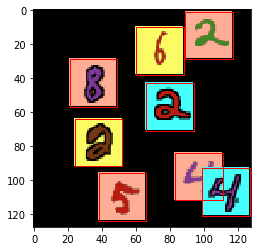

In [7]:
# Sample digits from MNIST 
class MNISTDataset(Dataset):
    def __init__(self, path='.', dataset='training', transform=None):
        self.target_transform = None
        self.path = path
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        # TODO: Replace this hard coding. 
        len = 60000
        return len

    def __getitem__(self, index):
        label = []
        color = []
        bgcolor = []
        style = []
        images = []
        x_coord, y_coord = [], []
        x_width, y_height = [], []
        boxes = list()

        # targetMap = initTargetMap(4)
        # checklist = getChecklist(img, targetMap)
        
        # Create a blank canvas 
        canvas = Image.new('RGB', (128, 128), 0)
        
        # sample random number of images to place on the canvas (max. 8)
        for rand_imgs in range(random.randint(3,8)):
            # img_data: JSON data that describe what the image must look like. Style and attributes. 
            img_data = generateGridImg(1)
            for i in range(len(img_data)):  # 4 for 4x4 grid
                for j in range(len(img_data)):
                    label.append(img_data[i][j]['number'])
                    color.append(img_data[i][j]['color'])
                    bgcolor.append(img_data[i][j]['bgcolor'])
                    style.append(img_data[i][j]['style'])

            self.numPools = self.getNumPools()
            self.colorMap = {'blue': [49, 89, 191], 'red': [186, 29, 18], 'green': [62, 140, 33], 'violet': [130, 58, 156],
                             'brown': [119, 57, 19], 'white': [255, 255, 255], 'cyan': [71, 255, 253],
                             'salmon': [255, 173, 148],
                             'yellow': [252, 251, 100], 'silver': [204, 204, 204]}

            for k in self.colorMap:
                self.colorMap[k] = np.array(self.colorMap[k], dtype='float32').reshape((1, 1, 3)) / 255

            # Pass img_data and MNIST digits to realizeGrid to generate a grid of digits. 
            img = self.realizeGrid(img_data, dataset=self.dataset)

            pil_img = Image.fromarray(np.uint8(img*255))
            x, y = random.randint(28, 28), random.randint(28, 28) # for resizing
            pil_img = pil_img.resize((x, y), Image.ANTIALIAS)
            x_width.append(x)
            y_height.append(y)
            images.append(pil_img)

        grid_size = len(images)  # for bbox

        x,y=[],[]
        iou_list = []
        ready=False
        position_found = False
        num_positions = 0
        position_find_attempts = 0

        while not ready:
            for i, im in enumerate(images):
                while position_find_attempts < 100:
                    cx=random.choice(range(0,100))
                    cy=random.choice(range(0,100))
                    x.append(cx)
                    y.append(cy)
                    box = make_bbox(cx, cy, 28, 28)
                    if i == 0:
                        position_found = True
                    else:
                        position_found = intersection_over_union(box, boxes)
                    if position_found:
                        break
                    position_find_attempts += 1

                if position_found:
                    boxes.append(box)
                    canvas.paste(im,(cx, cy))
                    num_positions +=1

                if num_positions==grid_size:
                    ready = True

        if self.transform is not None:
            canvas = self.transform(canvas)

        if self.target_transform is not None:
            label = np.array(label)
            label = self.transform(label)
#             color = self.transform(color)
#             bgcolor = self.transform(bgcolor)
#             style = self.transform(style)
#         boxes = self.make_bbox(x_coord, y_coord, x_width, y_height, grid_size=grid_size)
        for _ in range(len(boxes), 8):  # max 8 digits on the canvas
            label = np.hstack((label, [10]))
            boxes = np.vstack((boxes, np.array([-0.6, -0.6, 0.5, 0.5])))
        label = torch.tensor(label, dtype=torch.int8)
        boxes = torch.tensor(boxes, dtype=torch.float32)
#         boxes = torch.div(bboxes, torch.Tensor([128, 128, 128, 128]))

        return canvas, label, boxes, color, bgcolor, style

    def read(self, path='.', dataset='training'):
        if dataset is "training":
            fname_img = os.path.join(path, 'train-images-idx3-ubyte')
            fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
        elif dataset is "testing":
            fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
            fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
        else:
            raise ValueError("dataset must be 'testing' or 'training'")

            # Load everything in some numpy arrays
        with open(fname_lbl, 'rb') as flbl:
            magic, num = struct.unpack(">II", flbl.read(8))
            lbl = np.fromfile(flbl, dtype=np.int8)

        with open(fname_img, 'rb') as fimg:
            magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
            img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

        get_img = lambda idx: (lbl[idx], img[idx])

        # self.lbl = self.get_len(lbl)
        # Create an iterator which returns each image in turn
        for i in range(len(lbl)):
            yield get_img(i)

    # def get_len(self, lbl):
    #     self.lbl = len(lbl)
    #     return self.lbl

    def getNumPools(self):
        pools = {}
        for dataset in ['training', 'testing']:
            mnist = self.read(path=mnist_dir+'/MNISTDataset/raw')
            #mnist = self.read(path=mnist_dir+'\\data\\MNISTDataset\\raw')
            mnist = sorted(mnist, key=op.itemgetter(0))
            mnist = [(x[0], x[1].astype('float32') / 255) for x in mnist]

            numPools = []
            for i in range(9):  # for mnist digits
                count = 0
                for j in range(len(mnist)):
                    if mnist[j][0] != i:
                        break
                    count += 1
                numPools.append(mnist[:count])
                mnist = mnist[count:]
            numPools.append(mnist)

            pools[dataset] = numPools
        return pools

    def realizeSingleNumber(self, info, size=28, dataset='training'):
        palette = np.ones((size, size, 3), dtype='float32') * self.colorMap[info['bgcolor']]

        num_sample_idx = np.random.randint(len(self.numPools[dataset][info['number']]))
        num_sample = self.numPools[dataset][info['number']][num_sample_idx][1]

        if info['style'] == 'stroke':
            mask = grey_dilation(num_sample, (3, 3)).reshape((28, 28, 1))
            palette = palette * (1 - mask)

        mask = num_sample.reshape((size, size, 1))
        palette = palette * (1 - mask) + (mask * self.colorMap[info['color']]) * mask

        return palette

    def realizeGrid(self, gridImg, size=28, dataset='training'):
        "@returns: Grid of images based on json image data provided and MNIST dataset."
        img = np.zeros((size * len(gridImg), size * len(gridImg), 3))
        for i in range(len(gridImg)):
            for j in range(len(gridImg[i])):
                img[i * size:(i + 1) * size, j * size:(j + 1) * size, :] = self.realizeSingleNumber(gridImg[i][j],
                                                                                                    size=size,
                                                                                                  dataset=dataset)
        return img


mnist_dir = '.'
transform = transforms.Compose([
    transforms.ToTensor()
    ])

train_loader = DataLoader(
    MNISTDataset(mnist_dir, transform=transform),
    batch_size=1, shuffle=True)

# TODO: Attributes are string type. Process appropriately and convert to tensors.

for i, data in enumerate(train_loader):
    img, labels, bboxes, color, bgcolor, style = data
    # labels = torch.stack(labels)
    print(img.shape, labels.shape, bboxes.shape)
    print(labels[0])
    image = img[0].permute(1,2,0).numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    rect = []
    for i in range(bboxes.shape[1]):
        x = np.asarray(bboxes[0][i][0]).__int__()
        y = np.asarray(bboxes[0][i][1]).__int__()
        w = np.asarray(bboxes[0][i][2]).__int__()
        h = np.asarray(bboxes[0][i][3]).__int__()
        rect.append(patches.Rectangle((x, y), w, h,
                                      edgecolor='r',
                                      alpha=1,
                                      fill=False)) 
    ax.imshow(image)
    ax.add_collection(PatchCollection(rect, fc='none', ec='red'))
    break

# import pandas as pd
# from pandas.core.common import flatten
# df = pd.DataFrame(columns={'name', 'labels', 'bbox', 'color', 'bgcolor', 'style'})

# for i, data in enumerate(train_loader):
#     img, labels, bboxes, color, bgcolor, style = data
#     save_image(img, 'img.png', nrow=1)
#     d = {'name': '{idx}.png'.format(idx=i),
#          'labels': np.array2string(np.asarray(labels), separator=', '),
#          'bbox': np.array2string(np.asarray(bboxes), separator=', '),
#          'color': list(flatten(color)),
#          'bgcolor': list(flatten(bgcolor)),
#          'style': list(flatten(style))
#         }
#     df = df.append(d, ignore_index=True)
#     if i==2:
#         break
# df = df[['name', 'labels', 'bbox', 'color', 'bgcolor', 'style']]
# df.to_csv(mnist_dir+'/custom_mnist/annotations.csv')